# Part 3: Visualise

Firstly, we visualise the performance of the case with the best clustering results, as seen in the
previous part. We set the reduction dimension values according to the the optimised values we
got, which are: 200 for truncated SVD, 3 for PCA, and 2 for NMF (Non-logarithmic). In order to
make the clustering results easier to understand, we can plot the data points with different colors
and shapes, which stand different for the ground-truth label and the algorithm-clustered label.

In [1]:
from sklearn.datasets import fetch_20newsgroups
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from math import log
import matplotlib.pyplot as plt
import re


## Loading data

In [2]:
#Loading data
comp_subclasses=['comp.graphics','comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware','comp.sys.mac.hardware']
rec_subclasses=['rec.autos','rec.motorcycles','rec.sport.baseball','rec.sport.hockey']
  
data=fetch_20newsgroups(subset='all',categories=comp_subclasses+rec_subclasses,shuffle=True,random_state=42,
                        remove=('headers','footers','quotes'))

labels=[1]*len(data.data)
for i in range(len(data.data)):
    if data.target[i]>3:
        labels[i]=0

## Preprocessing the data

In [3]:
#Preprocessing the data by stripping off punctuations, removing stopwords, and stemming (it betters the performance, so we've included it)
punctuations='[! \" # $ % \& \' \( \) \* + , \- \. \/ : ; <=> ? @ \[ \\ \] ^ _ ` { \| } ~]'
stemmer=SnowballStemmer("english")
def remove_punctuation_and_stem(data_list):
    for i in range(len(data_list)):
        data_list[i]=" ".join([stemmer.stem(data) for data in re.split(punctuations,data_list[i])])
        data_list[i]=data_list[i].replace('\n','').replace('\t','').replace('\r','')
remove_punctuation_and_stem(data.data)


## Getting TF-IDF matrix

In [4]:
#Getting the TFxIDF matrix representation using min_df=3
vectorizer=TfidfVectorizer(max_features=10000,min_df=3,stop_words='english',use_idf=True)
X=vectorizer.fit_transform(data.data)
print(X.shape)

(7882, 10000)


## Making a function to plot clusters

In [5]:
#Plotting required results
def plot_clusters(actual_labels,clustered_labels,X_2d,centers,reducer):
    color=["r","b"]
    mark=["+","o"]
    for i in range(len(labels)):
        plt.scatter(X_2d[i,0],X_2d[i,1],s=12,marker=mark[actual_labels[i]],color=color[clustered_labels[i]],alpha=0.5)
    for i in range(2):
        plt.scatter(centers[i,0],centers[i,1],marker='^',s=100,linewidths=5,color='k',alpha=0.6)
    plt.title('Clustering results with ' + reducer)
    plt.show()

## Use K-means algorithm

In [6]:
km=KMeans(n_clusters=2,init='k-means++',max_iter=100,n_init=1)

**For the optimised case, the dimension of the final TF-IDF matrix is larger than 3, but we can
only plot nodes upto 3 dimensions. So, a solution for this, is to use the optimized dimension
reduction to process the TF-IDF matrix, and then apply the K-means algorithm. This would
re-reduce the matrix to 2-dimension to plot the graph.**

## Reduce dimensionality using SVD and plotting clusters

In [7]:
#Reduce dimensionality using SVD: best r value comes out to be 200, with n_iter=13
print('Performing truncatedSVD')
svd=TruncatedSVD(n_components=200,n_iter=13,random_state=42)
normalizer=Normalizer(copy=False)
lsa=make_pipeline(svd,normalizer)
X_reduced=lsa.fit_transform(X)

Performing truncatedSVD


In [8]:
km.fit(X_reduced)
clustered_labels=km.labels_

svd=TruncatedSVD(n_components=2,n_iter=13,random_state=42)
X_2d=svd.fit_transform(X)
km.fit(X_2d)
centers=km.cluster_centers_

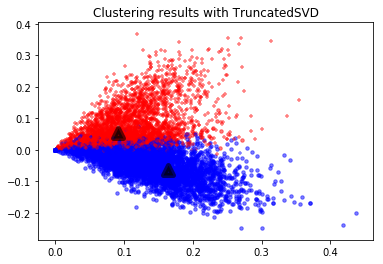

In [9]:
plot_clusters(labels,clustered_labels,X_2d,centers,'TruncatedSVD')

**In the plot of truncated SVD, we can see that the data points are distributed in a triangle-like
shape, and the ground-truth labels are approximately separated along the left angle bisector,
where the labels of data points above and below are likely different. Also, from the color, we can
see that, except for some false clustering near the bisector, the K-means algorithm separated the
data points along the bisector as well, which is consistent with the confusion matrix we inspected
before.**

## Reduce dimensionality using PCA and plotting its clusters

In [10]:
#Reduce dimensionality using PCA: best r value comes out to be 3
print('Performing PCA')
pca=PCA(n_components=3,random_state=42)
normalizer=Normalizer(copy=False)
lsa=make_pipeline(pca,normalizer)
X_reduced=lsa.fit_transform(X.toarray())

km.fit(X_reduced)
clustered_labels=km.labels_

pca=PCA(n_components=2,random_state=42)
X_2d=pca.fit_transform(X.toarray())
km.fit(X_2d)
centers=km.cluster_centers_

Performing PCA


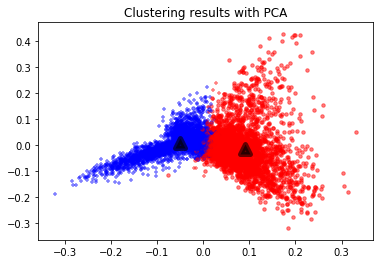

In [11]:
plot_clusters(labels,clustered_labels,X_2d,centers,'PCA')

**As for PCA reduction, the data points are distributed in an arrow-head-like shape. The K-means
algorithm separated them along the top bisector, which is also approximately the partition of the
ground truth.**

## Reducing Dimensionality using NMF without non-linear transformation and plotting its clusters

In [12]:
#Reduce dimensionality using NMF: best r value comes out to be 2
print('Performing NMF without any non-linear transformation')
nmf=NMF(n_components=2,random_state=42)
lsa=make_pipeline(nmf)
X_reduced=lsa.fit_transform(X)

km.fit(X_reduced)
clustered_labels=km.labels_
centers=km.cluster_centers_



Performing NMF without any non-linear transformation


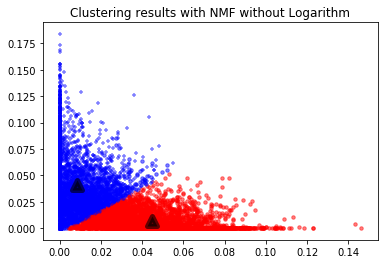

In [13]:
plot_clusters(labels,clustered_labels,X_reduced,centers,'NMF without Logarithm')

**In the plot for NMF reduction, the data points are mostly distributed beneath the (1/x) curve in
the plot, while the ground-truth labels are approximately separated along the bisector of the
90-degree angle, with a considerable amount of false. When the NMF reduction is applied
without the logarithmic transformation, the K-means algorithm separated the data points along
the bisector almost linearly, and therefore produced some false clustering points near the
bisector.**